En este tercer apartado deberéis realizar las siguientes tareas. El objetivo es encontrar el número de titulares similares entre las páginas web principales de dos periódicos. Considera como máximo 100 titulares.

- Tarea 1: Prepara el código necesario para descargar una página web pasando como parámetro la URL. Después extraerá todos los titulares.

- Tarea 2: Desarrolla otro método para calcular el número de titulares de la página principal de dos periódicos (haciendo uso del código de la tarea 1) que hacen referencia a la misma noticia. Para ello, deberás obtener los titulares de ambos periódicos y calcular el número de aquellos que excedan un determinado umbral de similaridad semántica.

# TITULARES SIMILARES

## ⚠️ Nota técnica: Geolocalización y reproducibilidad

**Observación**: En Google Colab, El País redirige automáticamente a
`https://elpais.com/us/` (versión USA) debido a la IP de los servidores,
mientras que en entornos locales europeos sirve la versión española estándar.

**Consecuencia**: Los titulares extraídos difieren entre entornos, lo que
explica variaciones en el número de coincidencias detectadas. Esto no afecta
la validez del sistema de similitud semántica implementado.

**Solución**: Para la **Tarea 2** (análisis de similitud semántica), se utilizarán titulares
almacenados en archivos csv cargados desde github, que han sido generado previamente desde VSCode para obtener los mismos resultados mencionados en la memoria.

In [2]:
elpais = "https://elpais.com"

elmundo = "https://www.elmundo.es"

## Tarea 1: Descarga de páginas web y extracción de titulares

In [3]:
import requests
from bs4 import BeautifulSoup
from typing import List
import re
import pandas as pd

### 1.1 Función para descargar la página web

In [4]:
def descargar_pagina(url:str, timeout:int=10) -> str:
    '''
    Método que descarga el contenido HTML de una página web

    Parámetros:
    -----------
    - url: URL de la página web
    - timeout: tiempo máximo de espera en segundos

    Retorna:
    --------
    Contenido HTML de la página, o None si falla.
    '''

    # El User-Agent es un encabezado HTTP que identifica el cliente (navegador o aplicación) que hace la petición al servidor web
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }

    try:
        response = requests.get(url, headers=headers, timeout=timeout)
        # Verificar código de estado HTTP
        response.raise_for_status()  # Raise excepcion si status code != 200
        return response.text

    except requests.exceptions.ConnectionError:
        print(f"Error de conexión: no se pudo conectar a {url}")
        return None
    except requests.exceptions.Timeout:
        print(f"Timeout: la petición tardó más de {timeout} segundos")
        return None
    except requests.exceptions.HTTPError as e:
        print(f"Error HTTP {e.response.status_code}: {url}")
        return None
    except Exception as e:
        print(f"Error inesperado: {str(e)}")
        return None

### 1.2 Función genérica para extraer titulares

In [5]:
def extraer_titulares_periodico(url_base:str, max_titulares:int=100) -> List[dict]:
    """
    Función principal para la Tarea 1: Descarga y extracción de titulares mediante estrategia dual con fallback

    Parámetros:
    -----------
    - url: URL del periódico a analizar
    - max_titulares: Número máximo de titulares a extraer (default: 100)

    Retorna:
    --------
    Lista de diccionarios con los titulares extraídos
    """
    # Paso 1: Descargar el contenido HTML
    html_content = descargar_pagina(url_base)
    if not html_content:
        print(f"Error: No se pudo descargar el contenido de la página web: {url_base}")
        return []

    # Paso 2: parsear
    soup = BeautifulSoup(html_content, 'html.parser')
    titulares = []

    # Paso 3: Extraer titulares

    # 1. Buscar en etiquetas <article>
    articulos = soup.find_all('article')
    for articulo in articulos:
        # Buscar <h2> o <h3> dentro de article
        titular_tag = articulo.find(['h2', 'h3', 'a'])
        if titular_tag:
            texto = titular_tag.get_text(strip=True)

            # Buscar el enlace asociado
            link = articulo.find('a', href=True)
            if link and len(texto) > 20:
                url = link['href']
                if url.startswith('/'):
                    url = url_base + url

                titulares.append({
                    'titular': texto,
                    'url': url
                })

    # 2. FALLBACK: Si no hay <article>, buscar por clases CSS comunes
    if len(titulares) < 10:
        # Inspeccionar manualmente y adaptar selectores
        titulares_h2 = soup.find_all('h2', class_=re.compile('(title|titular|headline)'))
        for h2 in titulares_h2:
            link = h2.find_parent('a') or h2.find('a')
            if link:
                titulares.append({
                    'titular': h2.get_text(strip=True),
                    'url': link.get('href', '')
                })

    # Limitar a 100 y eliminar duplicados
    titulares_unicos = []
    urls_vistas = set()
    for t in titulares:
        if t['url'] not in urls_vistas:
            titulares_unicos.append(t)
            urls_vistas.add(t['url'])

        if len(titulares_unicos) >= max_titulares:
            break
    return titulares_unicos


### 1.3 Ejemplos de uso

In [6]:
def visualizar_titulares(titulares:List[dict], url:str):
    if titulares:
        print(f"\nSe han extraído {len(titulares)} titulares de la URL: {url}\n")
        for i, noticia in enumerate(titulares[:10], 1):  # mostramos los 10 primeros
            print(f"{i:2d}: {noticia["titular"]}")

In [7]:
# Extraer titulares de El País
titulares_elpais = extraer_titulares_periodico(elpais)
visualizar_titulares(titulares_elpais, elpais)

# Extraer titulares de El Mundo
titulares_elmundo = extraer_titulares_periodico(elmundo)
visualizar_titulares(titulares_elmundo, elmundo)


Se han extraído 100 titulares de la URL: https://elpais.com

 1: Al menos 15 heridos por la caída de un muro de contención sobre un tren de Rodalies en Gelida (Barcelona)
 2: ¿Qué pasó en Adamuz? La secuencia entre el descarrilamiento y el choque
 3: El punto exacto del accidente superó hace dos meses un doble examen de seguridad de Adif
 4: Las grúas logran desplazar el Iryo y abren vía para que la maquinaria acceda al Alvia
 5: La noche del dolor para las familias en Córdoba: “Me desmayé al saber que no quedaban más heridos”
 6: Hay 39 personas hospitalizadas, 13 de ellas en la UCI
 7: Adif baja a 160 kilómetros por hora el límite de velocidad en parte de la línea Madrid-Barcelona
 8: Punta Umbría, el municipio más castigado, despide a cinco de sus vecinos: “Estoy viva. Gente de mi pueblo no lo está”
 9: Los Reyes visitan la zona: “Un país manifiesta su fortaleza por cómo se atienden las emergencias”
10: Sin noticias de Agustín, el hombre que se salvó del accidente de Angrois en 201

## Tarea 2:

### Preprocesamiento de los titulares

In [8]:
import re

def preprocesar_titular(texto:str) -> str:
    '''
    Aplica normalización y limipieza a un titular

    Parámetros:
    -----------
    texto: titular original

    Retorna:
    --------
    Texto normalizado
    '''
    # Paso 1: Convertir a minúsculas
    texto = texto.lower()

    # Paso 2: Normalizar comillas
    texto = re.sub(r'[""`´]', "", texto)

    # Paso 3: Eliminar URLs (si existen en titulares)
    texto = re.sub(r"http[s]?://\S+", "", texto)

    # Paso 4: Eliminar saltos de líneas y tabs
    texto = re.sub(r"[\n\t\r]", " ", texto)

    # Paso 5: Eliminar espacios extra
    texto = re.sub(r"\s+", " ", texto)

    texto = texto.strip()

    return texto



### Similitud semántica de titulares

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
import nltk
nltk.download("stopwords")


ModuleNotFoundError: No module named 'sentence_transformers'

In [ ]:
elmundo_csv = "https://raw.githubusercontent.com/aiambo08/Procesamiento-del-lenguaje-natural/refs/heads/main/titulares_elmundo.csv"
elpais_csv = "https://raw.githubusercontent.com/aiambo08/Procesamiento-del-lenguaje-natural/refs/heads/main/titulares_elpais.csv"


In [ ]:
def calcular_titulares_similares(archivo1:str, archivo2:str, umbral:float=0.7, max_titulares:int=100, metodo:str="embeddings"):
    """
    Detecta titulares semánticamente equivalentes entre dos periódicos

    Parámetros:
    -----------
    - archivo1, archivo2: Rutas de los archivos CSV con titulares
    - umbral: Umbral de similitud semántica [0,1]
    - max_titulares: Máximo de titulares a considerar por periódico
    - metodo: la estrategia que se emplea (embedings, tfidf)

    Retorna:
    --------
    Diccionario con estadísticas y pares similares
    """
    # Validación de parámetros
    if not (0<= umbral <=1):
        raise ValueError(f"Umbral debe estar en [0,1]")

    if metodo.lower() not in ["embeddings", "tfidf"]:
        raise ValueError(f"Solo es posible emplear los métodos embeddings o Tfidf")

    # Paso 1: Descargar y extraer titulares de ambos periódicos
    df1 = pd.read_csv(archivo1)
    titulares1 = df1.to_dict('records')
    df2 = pd.read_csv(archivo2)
    titulares2 = df2.to_dict('records')

    # Paso 2: Preprocesar titulares
    textos1 = [preprocesar_titular(t['titular']) for t in titulares1]
    textos2 = [preprocesar_titular(t['titular']) for t in titulares2]

    # Paso 3: ESTRATEGIA - tfidf/embeddings + similitud coseno
    stopwords_es = stopwords.words("spanish")

    if metodo.lower() == "tfidf":
        # captura coincidencias léxicas
        vectorizer = TfidfVectorizer(
            max_features=500,
            ngram_range=(1, 2),
            stop_words=stopwords_es
        )
        # ajusta con todos los titulares
        todos_textos = textos1 + textos2
        vectorizer.fit(todos_textos)

        # Transforma cada conjunto
        matriz1 = vectorizer.transform(textos1)
        matriz2 = vectorizer.transform(textos2)

    elif metodo.lower() == "embeddings":
        # captura coincidencias semánticas
        modelo = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        # Genera embeddings
        matriz1 = modelo.encode(textos1)
        matriz2 = modelo.encode(textos2)


    # Paso 4: Calcular similitud entre cada par de titulares
    similitudes = cosine_similarity(matriz1, matriz2)

    # Paso 5: Encontrar pares que superan el umbral
    pares_similares = []
    for i in range(len(titulares1)):
        for j in range(len(titulares2)):
            sim = similitudes[i, j]
            if sim >= umbral:
                pares_similares.append({
                    'titular1': titulares1[i]['titular'],
                    'titular2': titulares2[j]['titular'],
                    'similitud': sim,
                    'url1': titulares1[i]['url'],
                    'url2': titulares2[j]['url']
                })

    # Ordenar por similitud descendente
    pares_similares.sort(key=lambda x: x['similitud'], reverse=True)

    # Paso 6: Resultados
    resultado = {
        'num_titulares_periodico1': len(titulares1),
        'num_titulares_periodico2': len(titulares2),
        'umbral_similitud': umbral,
        'num_pares_similares': len(pares_similares),
        'pares': pares_similares
    }

    return resultado


### Buscamos el valor óptimo para el umbral

- El umbral de similitud es el valor mínimo de similitud coseno (entre 0 y 1) para considerar que dos titulares hablan de la misma noticia.

- Impacto directo:

    - Umbral bajo (0.5): Detecta más pares, pero incluye falsos positivos

    - Umbral alto (0.9): Solo pares casi idénticos, pierde noticias relacionadas

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

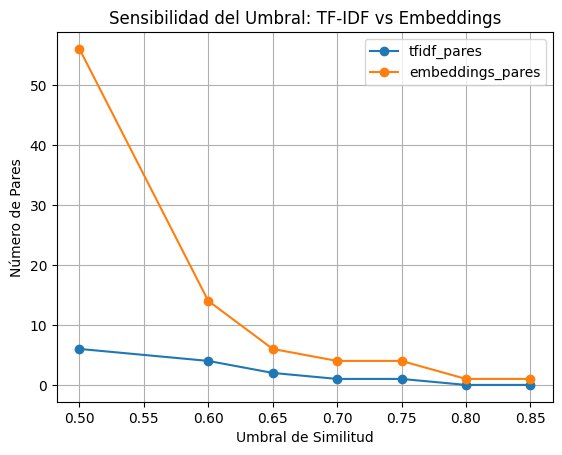

In [ ]:
umbrales = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
resultados_grid = []

for umbral in umbrales:
    res_tfidf = calcular_titulares_similares(elpais_csv, elmundo_csv, umbral=umbral, metodo='tfidf')
    res_emb = calcular_titulares_similares(elpais_csv, elmundo_csv, umbral=umbral, metodo='embeddings')

    resultados_grid.append({
        'umbral': umbral,
        'tfidf_pares': res_tfidf['num_pares_similares'],
        'embeddings_pares': res_emb['num_pares_similares']
    })

# Graficar
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(resultados_grid)
df.plot(x='umbral', y=['tfidf_pares', 'embeddings_pares'], marker='o')
plt.xlabel('Umbral de Similitud')
plt.ylabel('Número de Pares')
plt.title('Sensibilidad del Umbral: TF-IDF vs Embeddings')
plt.grid(True)
plt.show()


El umbral de similitud se estableció en **0.60** tras análisis de sensibilidad. Este valor  mantiene un recall aceptable, filtrando falsos positivos causados por coincidencias léxicas superficiales mientras preserva pares semánticamente equivalentes. Valores inferiores (0.5) incrementaban falsos positivos; valores superiores (0.7) reducían excesivamente el recall.

In [ ]:
# Ejecutar análisis

resultados = calcular_titulares_similares(
    elpais_csv,
    elmundo_csv,
    umbral=0.60
)

# Mostrar estadísticas
print("RESULTADOS: SIMILITUD ENTRE TITULARES")
print("-"*50)
print(f"Periódico 1: {resultados['num_titulares_periodico1']} titulares")
print(f"Periódico 2: {resultados['num_titulares_periodico2']} titulares")
print(f"Umbral de similitud: {resultados['umbral_similitud']}")
print(f"\nTitulares similares encontrados: {resultados['num_pares_similares']}\n")

# Mostrar top 10 pares más similares
print("TOP 10 PARES MÁS SIMILARES:\n")
for i, par in enumerate(resultados['pares'][:10], 1):
    print(f"{i}. Similitud: {par['similitud']:.3f}")
    print(f"    Periódico 1: {par['titular1']}")
    print(f"    Periódico 2: {par['titular2']}\n")


RESULTADOS: SIMILITUD ENTRE TITULARES
--------------------------------------------------
Periódico 1: 100 titulares
Periódico 2: 50 titulares
Umbral de similitud: 0.6

Titulares similares encontrados: 14

TOP 10 PARES MÁS SIMILARES:

1. Similitud: 0.898
    Periódico 1: Muere la actriz Brigitte Bardot, musa del cine francés y activista controvertida
    Periódico 2: Muere la actriz y activista francesa Brigitte Bardot a los 91 años

2. Similitud: 0.799
    Periódico 1: Aviso rojo en Murcia por el temporal que ha causado inundaciones en Málaga
    Periódico 2: Inundaciones y grandes crecidas de ríos en Málaga a causa del fuerte temporal

3. Similitud: 0.775
    Periódico 1: Aviso rojo en Murcia por el temporal que ha causado inundaciones en Málaga
    Periódico 2: Inundaciones por grandes crecidas de ríos en Málaga por el fuerte temporal

4. Similitud: 0.751
    Periódico 1: Muere el empresario Carles Vilarrubí, pilar de la creación de Catalunya Ràdio y exvicepresidente del Barça, a los